In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import ks_2samp, cramervonmises_2samp
%matplotlib inline  

In [166]:
def generate_points(
    centroids: list[np.ndarray],
    n_samples: int = 20,
    std: float = 0.2,
    drift_x: float = 0.0,
    drift_y: float = 0.0,
    factor_x: float = 1.0,
    factor_y: float = 1.0,
    seed: int | None = None,
):
    """
    Generates points from a normal distributation.

    Parameters
    ----------
    centroids : list[np.ndarray]
        A list of centroids.
    n_samples : int
        The number of points to generate per centroid.
    std : float
        The standard deviation of the source distribution.
    drift_x : float, default=0.0
        Applies a drift to the x-axis of all centroids.
    drift_y : float, default=0.0
        Applies a drift to the y-axis of all centroids.
    skew_x : float, default=1.0,
        Applies a scaling factor on the x-axis of all centroids.
    skew_y : float, default=1.0,
        Applies a scaling factor on the y-axis of all centroids.
    seed : int, default=0
        Sets the seed for numpy's random number generator.
    """
    if not isinstance(centroids, list):
        centroids = [centroids]
    if seed is not None:
        np.random.seed(seed)
    points = [
        np.random.normal(
            loc=centroid * np.array([factor_x, factor_y]) + np.array([drift_x, drift_y]),
            scale=std, 
            size=(n_samples, 2)
        )
        for centroid in centroids
    ]
    return np.vstack(points)

In [167]:
def compute_unique_distances(A, B, method: str = 'euclidean'):
    unique_distances = []
    for i in range(len(A)):
        for j in range(len(B)):
            if i <= j:
                distance = cdist(A[i:i+1], B[j:j+1], metric=method)
                unique_distances.append(distance)
    return np.array(unique_distances).flatten()


def compute_cvm(pointsA, pointsB, method: str = 'euclidean'):
    AtoA = compute_unique_distances(pointsA, pointsA)
    AtoB = compute_unique_distances(pointsA, pointsB)
    cvm = cramervonmises_2samp(AtoA, AtoB)
    return {
        "type": "CvM",
        "statistic": round(cvm.statistic, 3),
        "p-value": round(cvm.pvalue, 3),
    }


def compute_ks(pointsA, pointsB, method: str = 'euclidean'):
    AtoA = compute_unique_distances(pointsA, pointsA)
    AtoB = compute_unique_distances(pointsA, pointsB)
    ks = ks_2samp(AtoA, AtoB)
    return {
        "type": "KS",
        "statistic": round(ks.statistic, 3),
        "p-value": round(ks.pvalue, 3),
    }

# Identify drift within a dataset.

In [168]:
n_samples = 100  # per centroid
drift_translation = np.array([0.0, 0.5])

label_A = np.array([2,3])
label_B = np.array([1,2])
label_C = np.array([3,2])

centroids = [label_A, label_B, label_C]
centroids_with_drift = [
    label_A + drift_translation, 
    label_B,
    label_C,
]

points_A_sample1 = generate_points(centroids, n_samples=n_samples)
points_A_sample2 = generate_points(centroids, n_samples=n_samples)
points_A_drifted1 = generate_points(centroids_with_drift, n_samples=n_samples)
points_A_drifted2 = generate_points(centroids_with_drift, n_samples=n_samples)

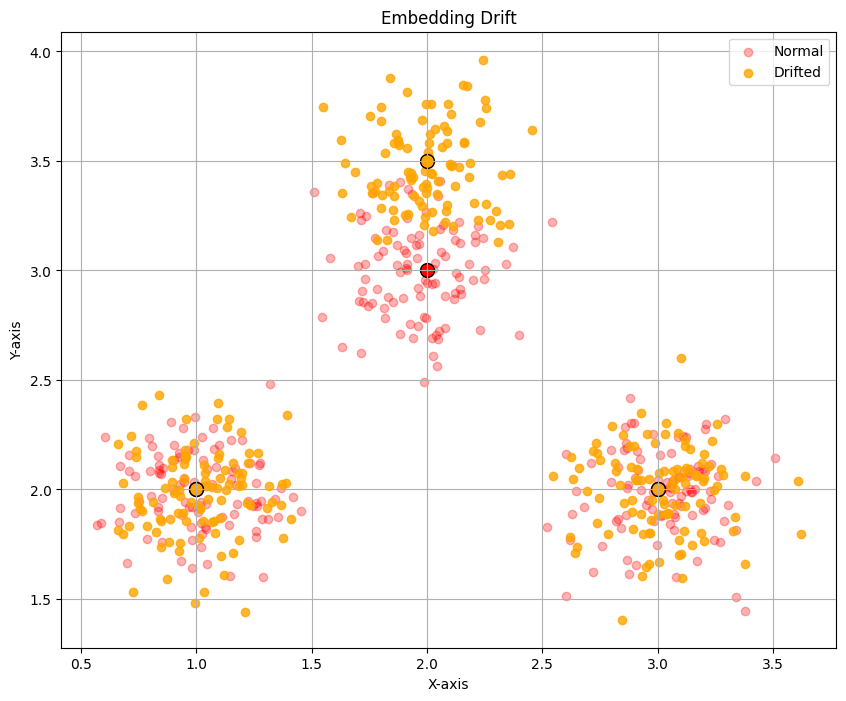

In [169]:
# Scatter plot points
plt.figure(figsize=(10, 8))
plt.scatter(points_A_sample1[:, 0], points_A_sample1[:, 1], color='red', alpha=0.3, label='Normal')
plt.scatter(points_A_drifted1[:, 0], points_A_drifted1[:, 1], color='orange', alpha=0.8, label='Drifted')
for centroid in centroids:
    plt.scatter(centroid[0], centroid[1], color='red', edgecolor='black', s=100)
for centroid in centroids_with_drift:
    plt.scatter(centroid[0], centroid[1], color='orange', edgecolor='black', s=100)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Embedding Drift')
plt.legend()
plt.grid(True)
plt.show()


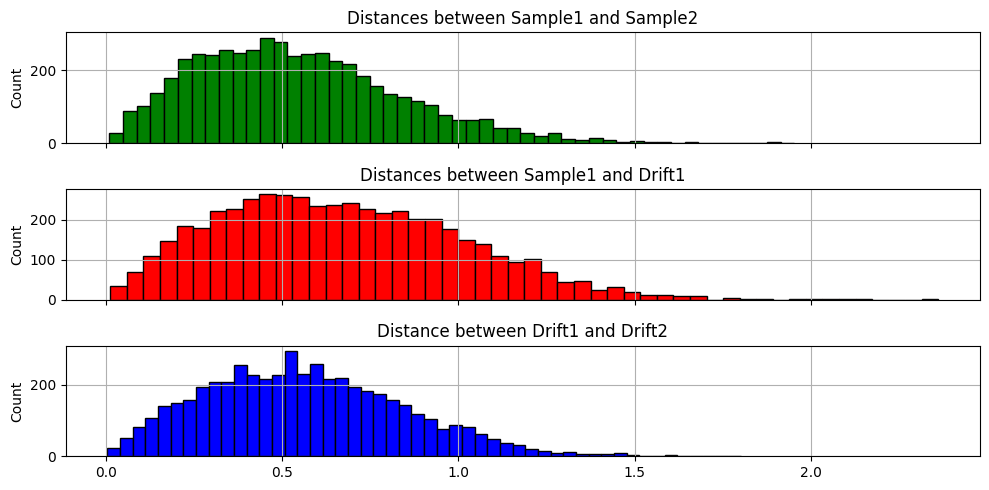

0.295841645278342
0.34221796544170147


In [177]:
# Plot histogram of point distances.
distances_to_sample1 = compute_unique_distances(points_A_sample1, points_A_sample1)
distances_to_sample2 = compute_unique_distances(points_A_sample1, points_A_sample2)
distances_to_drifted1 = compute_unique_distances(points_A_sample1, points_A_drifted1)
distances_drifted1_to_drifted1 = compute_unique_distances(points_A_drifted1, points_A_drifted1)
distances_drifted1_to_drifted2 = compute_unique_distances(points_A_drifted1, points_A_drifted2)

fig, axes = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

axes[0].hist(distances_to_sample2, bins=50, color='green', edgecolor='black')
axes[0].set_title('Distances between Sample1 and Sample2')
axes[0].set_ylabel('Count')
axes[0].grid(True)

axes[1].hist(distances_to_drifted1, bins=50, color='red', edgecolor='black')
axes[1].set_title('Distances between Sample1 and Drift1')
axes[1].set_ylabel('Count')
axes[1].grid(True)

axes[2].hist(distances_drifted1_to_drifted2, bins=50, color='blue', edgecolor='black')
axes[2].set_title('Distance between Drift1 and Drift2')
axes[2].set_ylabel('Count')
axes[2].grid(True)

plt.tight_layout()
plt.show()

print(np.std(distances_to_sample1))
print(np.std(distances_to_drifted1))


In [171]:
metrics = []

# normal to normal
cvm = compute_cvm(points_A_sample1, points_A_sample2)
ks = compute_ks(points_A_sample1, points_A_sample2)
cvm["comparison"] = "Original"
ks["comparison"] = "Original"
metrics.append(cvm)
metrics.append(ks)

# normal to drifted
cvm = compute_cvm(points_A_sample1, points_A_drifted1)
ks = compute_ks(points_A_sample1, points_A_drifted1)
cvm["comparison"] = "Cross"
ks["comparison"] = "Cross"
metrics.append(cvm)
metrics.append(ks)

# drifted to ddrift
cvm = compute_cvm(points_A_drifted1, points_A_drifted2)
ks = compute_ks(points_A_drifted1, points_A_drifted2)
cvm["comparison"] = "Drifted"
ks["comparison"] = "Drifted"
metrics.append(cvm)
metrics.append(ks)

df = pd.DataFrame(metrics)
df.sort_values(by=["type", "statistic"], ascending=[True, False])

,type,statistic,p-value,comparison
2,CvM,7.161,0.0,Cross
0,CvM,4.795,0.0,Original
4,CvM,1.536,0.0,Drifted
3,KS,0.040,0.0,Cross
1,KS,0.026,0.0,Original
5,KS,0.016,0.0,Drifted


# Isolate the label causing the drifted distribution

In [172]:

n_samples = 100  # per centroid
drift_translation = np.array([0.0, 0.5])
std = 0.3

label_A = np.array([2,3])

centroids = [label_A]
centroids_with_drift = [label_A + drift_translation]

points_A_sample1 = generate_points(centroids, n_samples=n_samples, std=std)
points_A_sample2 = generate_points(centroids, n_samples=n_samples, std=std)
points_A_drifted1 = generate_points(centroids_with_drift, n_samples=n_samples, std=std)
points_A_drifted2 = generate_points(centroids_with_drift, n_samples=n_samples, std=std)

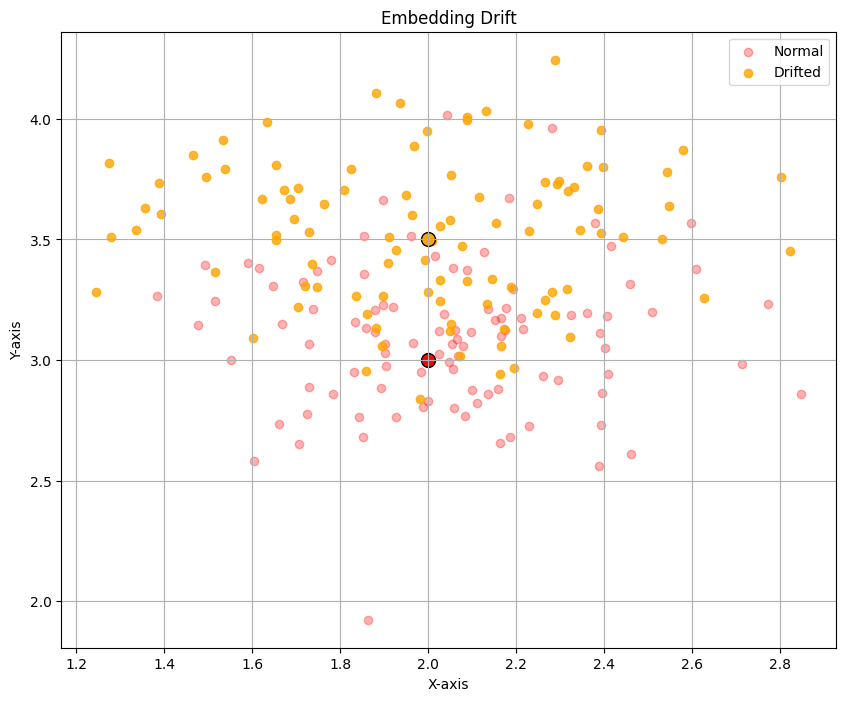

In [173]:
# Scatter plot points
plt.figure(figsize=(10, 8))
plt.scatter(points_A_sample1[:, 0], points_A_sample1[:, 1], color='red', alpha=0.3, label='Normal')
plt.scatter(points_A_drifted1[:, 0], points_A_drifted1[:, 1], color='orange', alpha=0.8, label='Drifted')
for centroid in centroids:
    plt.scatter(centroid[0], centroid[1], color='red', edgecolor='black', s=100)
for centroid in centroids_with_drift:
    plt.scatter(centroid[0], centroid[1], color='orange', edgecolor='black', s=100)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Embedding Drift')
plt.legend()
plt.grid(True)
plt.show()

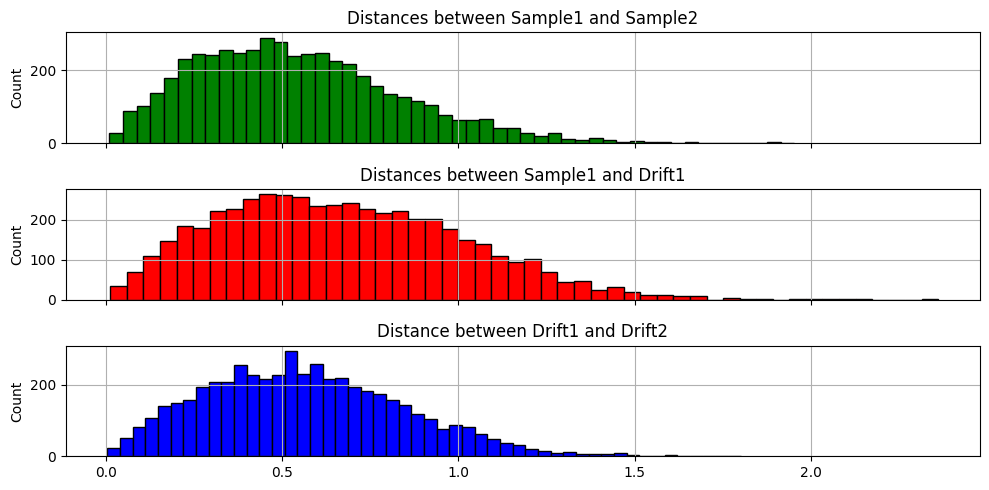

In [174]:
# Plot histogram of point distances.
distances_to_sample1 = compute_unique_distances(points_A_sample1, points_A_sample1)
distances_to_sample2 = compute_unique_distances(points_A_sample1, points_A_sample2)
distances_to_drifted1 = compute_unique_distances(points_A_sample1, points_A_drifted1)
distances_drifted1_to_drifted1 = compute_unique_distances(points_A_drifted1, points_A_drifted1)
distances_drifted1_to_drifted2 = compute_unique_distances(points_A_drifted1, points_A_drifted2)

fig, axes = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

axes[0].hist(distances_to_sample2, bins=50, color='green', edgecolor='black')
axes[0].set_title('Distances between Sample1 and Sample2')
axes[0].set_ylabel('Count')
axes[0].grid(True)

axes[1].hist(distances_to_drifted1, bins=50, color='red', edgecolor='black')
axes[1].set_title('Distances between Sample1 and Drift1')
axes[1].set_ylabel('Count')
axes[1].grid(True)

axes[2].hist(distances_drifted1_to_drifted2, bins=50, color='blue', edgecolor='black')
axes[2].set_title('Distance between Drift1 and Drift2')
axes[2].set_ylabel('Count')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [175]:
metrics = []

# normal to normal
cvm = compute_cvm(points_A_sample1, points_A_sample2)
ks = compute_ks(points_A_sample1, points_A_sample2)
cvm["comparison"] = "Original"
ks["comparison"] = "Original"
metrics.append(cvm)
metrics.append(ks)

# normal to drifted
cvm = compute_cvm(points_A_sample1, points_A_drifted1)
ks = compute_ks(points_A_sample1, points_A_drifted1)
cvm["comparison"] = "Crossed"
ks["comparison"] = "Crossed"
metrics.append(cvm)
metrics.append(ks)

# drifted to drifted
cvm = compute_cvm(points_A_drifted1, points_A_drifted2)
ks = compute_ks(points_A_drifted1, points_A_drifted2)
cvm["comparison"] = "Drifted"
ks["comparison"] = "Drifted"
metrics.append(cvm)
metrics.append(ks)

df = pd.DataFrame(metrics)
df.sort_values(by="type")
df.sort_values(by=["type", "statistic"], ascending=[True, False])

,type,statistic,p-value,comparison
2,CvM,53.004,0.000,Crossed
0,CvM,2.775,0.000,Original
4,CvM,0.505,0.039,Drifted
3,KS,0.201,0.000,Crossed
1,KS,0.051,0.000,Original
5,KS,0.027,0.057,Drifted


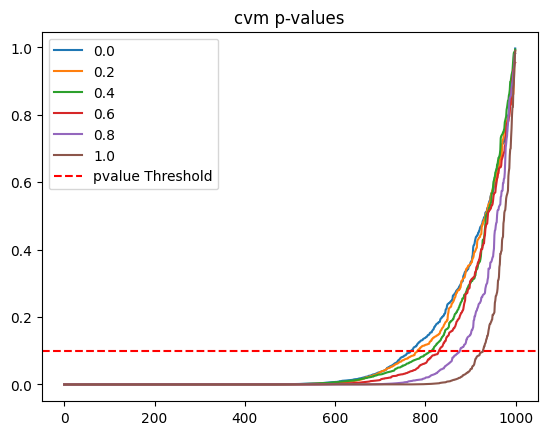

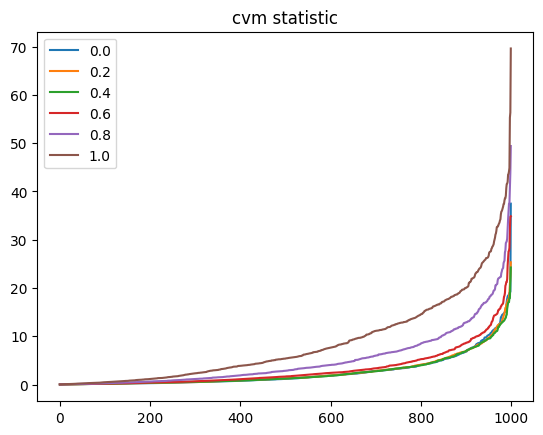

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import cramervonmises_2samp, ks_2samp

def generate(loc=0.0):
    base = np.random.normal(size=(100, 10)) # 100 embeddings, 10 dimensions
    control_query = np.random.normal(size=(100, 10)) # 100 embedding, 10 dimensions
    queries = np.random.normal(loc=[loc,0,0,0,0,0,0,0,0,0], size=(100, 10)) # 100 embedding, 10 dimensions

    control_dist = cdist(base, control_query)
    control_dist = control_dist.flatten()

    distances = cdist(base, queries)
    distances = distances.flatten()

    cvms = cramervonmises_2samp(control_dist, distances)
    kss = ks_2samp(control_dist, distances)
    return (cvms, kss)

locs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
cvms = [
    [
        generate(loc)[0]
        for _ in range(1000)
    ]
    for loc in locs
]
cvm_pvalues = [
    sorted([
        float(metric.pvalue)
        for metric in cvm
    ])
    for cvm in cvms
]
cvm_statistics = [
    sorted([
        float(metric.statistic)
        for metric in cvm
    ])
    for cvm in cvms
]

plt.figure()
for offset, metric in zip(locs, cvm_pvalues):
    plt.plot(metric, label=str(offset))
plt.title("cvm p-values")
plt.axhline(y=0.1, color='r', linestyle='--', label='pvalue Threshold')
plt.legend()
plt.show()

plt.figure()
for offset, metric in zip(locs, cvm_statistics):
    plt.plot(metric, label=str(offset))
plt.title("cvm statistic")
plt.legend()
plt.show()

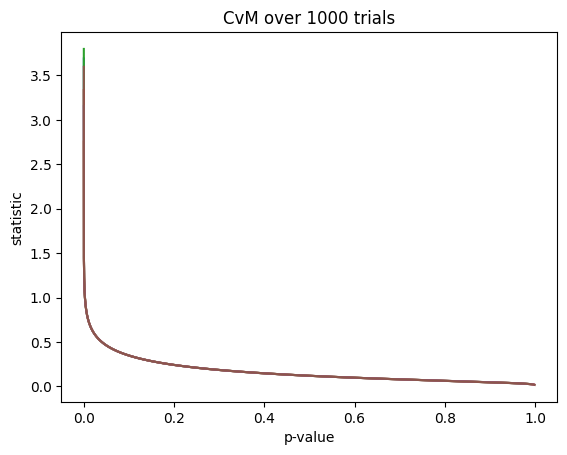

In [16]:
coords = [
    {
        "offset": offset,
        "coords": sorted(
            [
                [cvm.pvalue, cvm.statistic]
                for cvm in cvms[idx]
            ],
            key=lambda x: x[0]
        )
    }
    for idx, offset in enumerate(locs)
]

plt.figure()
for coord in coords:
    xy = np.array(coord["coords"])
    plt.plot(xy[:, 0], xy[:, 1], label=coord["offset"])
plt.xlabel('p-value')
plt.ylabel('statistic')
plt.title("CvM over 100 trials")
plt.show()